In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [33]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("/content/FEMA Preprocessed Data.csv")

numeric_columns = ["ihProgramDeclared", "iaProgramDeclared", "paProgramDeclared",
                   "hmProgramDeclared", "incidentDuration"]
non_numeric_columns = [col for col in df.columns if col not in numeric_columns]

for col in numeric_columns:
    df[col] = df[col].fillna(df[col].mean())

for col in non_numeric_columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode().iloc[0])
    else:
        df[col] = df[col].fillna(df[col].mean())


scaler = MinMaxScaler()
numeric_scaled = scaler.fit_transform(df[numeric_columns])

subset_indices = np.random.choice(len(numeric_scaled), size=len(numeric_scaled) // 3, replace=False)
subset_scaled = numeric_scaled[subset_indices]

nn = NearestNeighbors(n_neighbors=5, metric="cosine").fit(numeric_scaled)
distances, indices = nn.kneighbors(subset_scaled)

synthetic_numeric_data = []
for i, neighbors in enumerate(indices):
    for neighbor in neighbors[1:]:
        row1 = subset_scaled[i]
        row2 = numeric_scaled[neighbor]
        synthetic_row = row1 + np.random.uniform(0.2, 0.8) * (row2 - row1)
        synthetic_numeric_data.append(synthetic_row)

synthetic_numeric_df = pd.DataFrame(synthetic_numeric_data, columns=numeric_columns)

synthetic_non_numeric_df = df[non_numeric_columns].sample(len(synthetic_numeric_df), replace=True, random_state=42).reset_index(drop=True)

if "declarationDate" in synthetic_non_numeric_df.columns:
    df["declarationDate"] = pd.to_datetime(df["declarationDate"], format="%Y-%m-%d %H:%M:%S%z")

    max_date = df["declarationDate"].max()

    unique_dates = pd.date_range(start=max_date + pd.Timedelta(days=1), periods=len(synthetic_numeric_df), freq='D')
    unique_dates_formatted = unique_dates.strftime("%Y-%m-%d %H:%M:%S+00:00")

    synthetic_non_numeric_df["declarationDate"] = unique_dates_formatted

synthetic_df = pd.concat([synthetic_numeric_df, synthetic_non_numeric_df], axis=1)

augmented_df = pd.concat([df, synthetic_df], ignore_index=True)

augmented_df.to_csv("augmented_dataset.csv", index=False)
print("Synthetic data with non-numeric handling saved as augmented_dataset.csv")

Synthetic data with non-numeric handling saved as augmented_dataset.csv


Convert the "declarationDate" column to datetime to ensure consistency

Determine the latest date in the original dataset

Generate unique dates starting from the day after the latest date, preserving the format

Assign the formatted unique dates to the synthetic data

Fill with most frequent value

In [34]:
df = pd.read_csv('/content/augmented_dataset.csv')

In [35]:
df.dropna(subset=['incidentType'], inplace=True)
df.fillna({'incidentDuration': df['incidentDuration'].median()}, inplace=True)

In [36]:
date_columns = ['declarationDate', 'incidentBeginDate', 'incidentEndDate']
for col in date_columns:
    df[col] = pd.to_datetime(df[col])

In [37]:
df['incidentDuration'] = (df['incidentEndDate'] - df['incidentBeginDate']).dt.days
df['year'] = df['declarationDate'].dt.year
df['month'] = df['declarationDate'].dt.month
df['day_of_week'] = df['declarationDate'].dt.dayofweek

In [38]:
label_encoder = LabelEncoder()
df['incidentType'] = label_encoder.fit_transform(df['incidentType'])

In [39]:
X = df[['year', 'month', 'day_of_week', 'incidentDuration', 'fipsStateCode', 'fipsCountyCode']]
y = df['incidentType']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

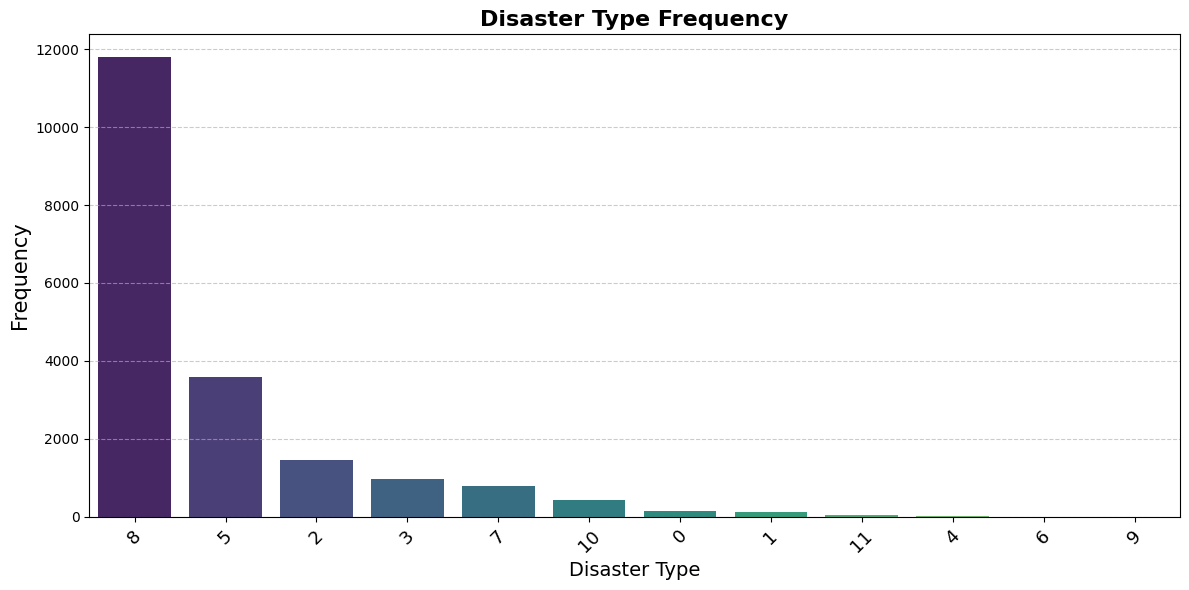

In [42]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='incidentType',
              order=df['incidentType'].value_counts().index,
              palette='viridis')
plt.title('Disaster Type Frequency', fontsize=16, fontweight='bold')
plt.xlabel('Disaster Type', fontsize=14)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(rotation=45, fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.65)
plt.tight_layout()
plt.show()

In [43]:
import warnings
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [44]:
warnings.filterwarnings("ignore")

In [45]:
param_grids = {
    'Logistic Regression': {'model__C': [0.01, 0.1, 1, 10]},
    'Decision Tree': {'model__max_depth': [3, 5, 10, None]},
    'Random Forest': {'model__n_estimators': [50, 100, 200], 'model__max_depth': [3, 5, 10, None]},
    'Gradient Boosting': {'model__learning_rate': [0.01, 0.1, 0.2], 'model__n_estimators': [50, 100, 200]},
    'SVM': {'model__C': [0.01, 0.1, 1, 10], 'model__kernel': ['linear', 'rbf']}
}

In [46]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [47]:
model_pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=200))
    ]),
    'Decision Tree': Pipeline([
        ('model', DecisionTreeClassifier())
    ]),
    'Random Forest': Pipeline([
        ('model', RandomForestClassifier(random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('model', GradientBoostingClassifier(random_state=42))
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(probability=True, random_state=42))
    ])
}

In [48]:
results = []

In [51]:
from sklearn.preprocessing import label_binarize

for model_name, pipeline in model_pipelines.items():
    print(f"\nTraining {model_name}...\n" + "=" * 40)

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[model_name],
        scoring='f1_weighted',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}\n")

    y_pred = best_model.predict(X_test)
    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(X_test)
    else:
        y_prob = None

    if y_prob is not None:
        if len(set(y_test)) > 2:
            y_test_binarized = label_binarize(y_test, classes=list(range(y_prob.shape[1])))
            auc_score = roc_auc_score(y_test_binarized, y_prob, multi_class='ovr', average='weighted')
        else:
            auc_score = roc_auc_score(y_test, y_prob[:, 1])
    else:
        auc_score = 'N/A'

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'AUC': auc_score
    }
    results.append(metrics)

    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("=" * 40)

results_df = pd.DataFrame(results)


Training Logistic Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters for Logistic Regression: {'model__C': 0.1}

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.00      0.00      0.00        25
           2       0.60      0.56      0.58       283
           3       0.00      0.00      0.00       191
           4       0.00      0.00      0.00         4
           5       0.50      0.03      0.06       723
           7       0.00      0.00      0.00       147
           8       0.64      0.97      0.78      2357
          10       0.00      0.00      0.00       103
          11       0.00      0.00      0.00        10

    accuracy                           0.64      3877
   macro avg       0.17      0.16      0.14      3877
weighted avg       0.53      0.64      0.53      3877


Training Decision Tree...
Fitting 5 fol

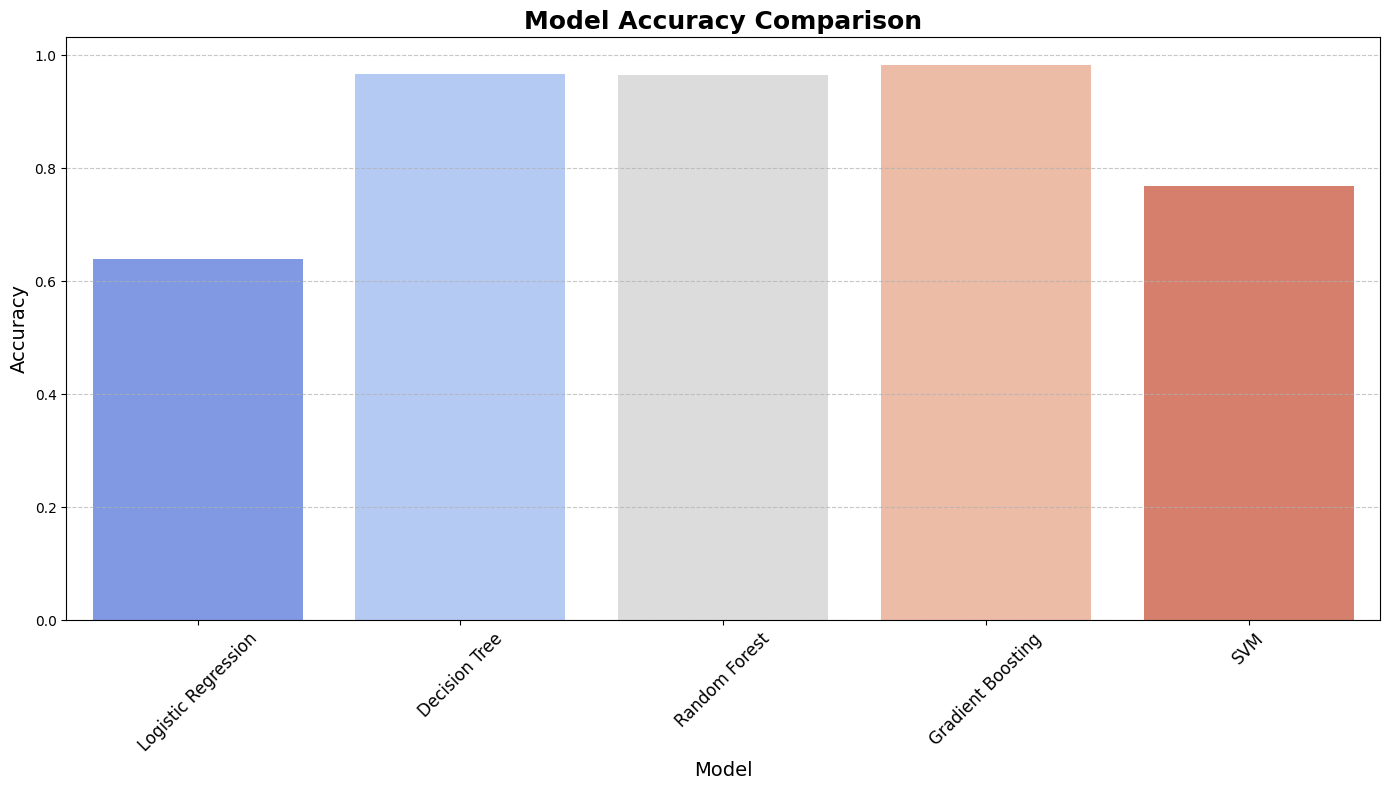


Final Model Comparison:
               Model  Accuracy  Precision   Recall  F1-Score      AUC
  Gradient Boosting  0.982461   0.982554 0.982461  0.982448 0.998679
      Decision Tree  0.967243   0.967436 0.967243  0.967292 0.969815
      Random Forest  0.965437   0.966035 0.965437  0.964616 0.997443
                SVM  0.768120   0.789643 0.768120  0.735253 0.882623
Logistic Regression  0.639154   0.528623 0.639154  0.525655 0.659053


In [52]:
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='coolwarm')
plt.title('Model Accuracy Comparison', fontsize=18, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display performance metrics in a sorted DataFrame
print("\nFinal Model Comparison:\n", results_df.sort_values(by='F1-Score', ascending=False).to_string(index=False))